<b><font size="6">Assignment 4<br>Visualisierung der Brexit-Tweets mit Spark (ohne SQL)</font></b>

**BDT ILV bds19: Big Data Technologien ILV**  
**Data Science & Business Analytics**

Autor: Thomas Schrittwieser, DS191004  
Datum: 2020-12-15

---

# Aufgabenstellung

Erweitern Sie das beigefügte Jupyter Notebook um den Split in Leave- und Remain-Befürworter anhand der Hashtags wie in der letzten Aufgabe - mit Hilfe der Spark DataFrame API.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# matplotlib styles
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("jupyter").getOrCreate()
#spark = SparkSession.builder.appName("jupyter").master("spark://hadoop.priebe.io:7077").getOrCreate()
#sc = spark.sparkContext

In [4]:
# Set pointer on csv-file
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .load("hdfs://hadoop.priebe.io:9000/user/lbpriebe/sentiment/brexit_sentiment.csv")

In [5]:
# Show dataframe & schema
df.show(5)
df.printSchema()

+----------+------------------+-------------------+--------------------+
| sentiment|                id|            created|            hashtags|
+----------+------------------+-------------------+--------------------+
|0.23544335|736284933686239233|2016-05-27T19:56:22|              brexit|
| 0.9788283|736284905710211073|2016-05-27T19:56:15|euref|strongerin|...|
|0.76723874|736284877084065792|2016-05-27T19:56:08|brexit|voteremain...|
|0.43008626|736284846151106563|2016-05-27T19:56:01|              brexit|
| 0.7955383|736284840992092160|2016-05-27T19:56:00|        brexit|euref|
+----------+------------------+-------------------+--------------------+
only showing top 5 rows

root
 |-- sentiment: double (nullable = true)
 |-- id: long (nullable = true)
 |-- created: string (nullable = true)
 |-- hashtags: string (nullable = true)



In [6]:
# Convert timestamp
from pyspark.sql.types import *
from pyspark.sql.functions import unix_timestamp

df = df.withColumn("created", unix_timestamp(df['created'], "yyyy-MM-dd'T'HH:mm:ss").cast(TimestampType()))
df.show(5)
df.printSchema()

+----------+------------------+-------------------+--------------------+
| sentiment|                id|            created|            hashtags|
+----------+------------------+-------------------+--------------------+
|0.23544335|736284933686239233|2016-05-27 19:56:22|              brexit|
| 0.9788283|736284905710211073|2016-05-27 19:56:15|euref|strongerin|...|
|0.76723874|736284877084065792|2016-05-27 19:56:08|brexit|voteremain...|
|0.43008626|736284846151106563|2016-05-27 19:56:01|              brexit|
| 0.7955383|736284840992092160|2016-05-27 19:56:00|        brexit|euref|
+----------+------------------+-------------------+--------------------+
only showing top 5 rows

root
 |-- sentiment: double (nullable = true)
 |-- id: long (nullable = true)
 |-- created: timestamp (nullable = true)
 |-- hashtags: string (nullable = true)



In [7]:
# Extract date from column created_date
from pyspark.sql.functions import to_date, col

df = df.withColumn("created_date", to_date(col("created")))
df.show(5)
df.printSchema()

+----------+------------------+-------------------+--------------------+------------+
| sentiment|                id|            created|            hashtags|created_date|
+----------+------------------+-------------------+--------------------+------------+
|0.23544335|736284933686239233|2016-05-27 19:56:22|              brexit|  2016-05-27|
| 0.9788283|736284905710211073|2016-05-27 19:56:15|euref|strongerin|...|  2016-05-27|
|0.76723874|736284877084065792|2016-05-27 19:56:08|brexit|voteremain...|  2016-05-27|
|0.43008626|736284846151106563|2016-05-27 19:56:01|              brexit|  2016-05-27|
| 0.7955383|736284840992092160|2016-05-27 19:56:00|        brexit|euref|  2016-05-27|
+----------+------------------+-------------------+--------------------+------------+
only showing top 5 rows

root
 |-- sentiment: double (nullable = true)
 |-- id: long (nullable = true)
 |-- created: timestamp (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- created_date: date (nullable = true)

In [8]:
# Create dataframe for brexit supporters

# hashtags_leave: #Leave, #VoteLeave, #TakeControl, #VoteOut
# hashtags_remain: #Remain, #VoteRemain, #StrongerIn, #VoteIn
leave = "hashtags like '%leave%' or hashtags like '%voteleave%' or hashtags like '%takecontrol%' or hashtags like '%voteout%'"
leave_not = "hashtags not like '%remain%' and hashtags not like '%voteremain%' and hashtags not like '%strongerin%' and hashtags not like '%votein%'"

df_leave = df.where(leave).where(leave_not)
df_leave.show(5)

+-----------+------------------+-------------------+--------------------+------------+
|  sentiment|                id|            created|            hashtags|created_date|
+-----------+------------------+-------------------+--------------------+------------+
|  0.9860322|736284627640410112|2016-05-27 19:55:09|           voteleave|  2016-05-27|
|  0.6463591|736284563173953537|2016-05-27 19:54:54|           voteleave|  2016-05-27|
|  0.9539134|736284326917066752|2016-05-27 19:53:57|voteleave|brexit|...|  2016-05-27|
|0.061895013|736284169987366912|2016-05-27 19:53:20|           voteleave|  2016-05-27|
| 0.17585549|736283851937439749|2016-05-27 19:52:04|joncker|brexit|eu...|  2016-05-27|
+-----------+------------------+-------------------+--------------------+------------+
only showing top 5 rows



In [9]:
# Create dataframe for brexit opponents

# hashtags_leave: #Leave, #VoteLeave, #TakeControl, #VoteOut
# hashtags_remain: #Remain, #VoteRemain, #StrongerIn, #VoteIn
remain = "hashtags like '%remain%' or hashtags like '%voteremain%' or hashtags like '%strongerin%' or hashtags like '%votein%'"
remain_not = "hashtags not like '%leave%' and hashtags not like '%voteleave%' and hashtags not like '%takecontrol%' and hashtags not like '%voteout%'"

df_remain = df.where(remain).where(remain_not)
df_remain.show(5)

+----------+------------------+-------------------+--------------------+------------+
| sentiment|                id|            created|            hashtags|created_date|
+----------+------------------+-------------------+--------------------+------------+
| 0.9788283|736284905710211073|2016-05-27 19:56:15|euref|strongerin|...|  2016-05-27|
|0.22018415|736284808620429312|2016-05-27 19:55:52|          strongerin|  2016-05-27|
|0.42039508|736284655268302849|2016-05-27 19:55:15|          strongerin|  2016-05-27|
|0.11619088|736284536846340096|2016-05-27 19:54:47|              remain|  2016-05-27|
|  0.984395|736284521629384705|2016-05-27 19:54:44|  liberal|strongerin|  2016-05-27|
+----------+------------------+-------------------+--------------------+------------+
only showing top 5 rows



In [10]:
# group by created date
df_leave = df_leave.groupBy("created_date").avg("sentiment")
#df_leave.show(5)

# rename column "avg(sentiment)" nach "sentiment"
df_leave = df_leave.select(col("created_date"), col("avg(sentiment)").alias("sentiment"))
#df_leave.show(5)

# sort by date
df_leave = df_leave.orderBy('created_date')
df_leave.show(5)

+------------+------------------+
|created_date|         sentiment|
+------------+------------------+
|  2016-05-27| 0.596002000947028|
|  2016-05-28|0.5854471264903025|
|  2016-05-29|0.5777290610841352|
|  2016-05-30|0.5827555062301584|
|  2016-05-31|0.5680278756547736|
+------------+------------------+
only showing top 5 rows



In [11]:
# group by created date
df_remain = df_remain.groupBy("created_date").avg("sentiment")
#df_remain.show(5)

# rename column "avg(sentiment)" nach "sentiment"
df_remain = df_remain.select(col("created_date"), col("avg(sentiment)").alias("sentiment"))
#df_remain.show(5)

# sort by date
df_remain = df_remain.orderBy('created_date')
df_remain.show(5)

+------------+------------------+
|created_date|         sentiment|
+------------+------------------+
|  2016-05-27|0.5801412707694144|
|  2016-05-28|0.6435413185081684|
|  2016-05-29|0.6070059807585179|
|  2016-05-30|0.6247788086584546|
|  2016-05-31| 0.591470200469405|
+------------+------------------+
only showing top 5 rows



In [12]:
# convert to pandas_df
df_leave = df_leave.toPandas()
df_leave['created_date'] = pd.to_datetime(df_leave['created_date'])

df_remain = df_remain.toPandas()
df_remain['created_date'] = pd.to_datetime(df_remain['created_date'])

In [13]:
# statistical analysis of brexit supporters
df_leave.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,31.0,0.582419,0.027254,0.541109,0.568451,0.577729,0.589739,0.679834


In [14]:
# statistical analysis of brexit opponents
df_remain.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,31.0,0.588893,0.031744,0.501721,0.580064,0.586691,0.603642,0.663606


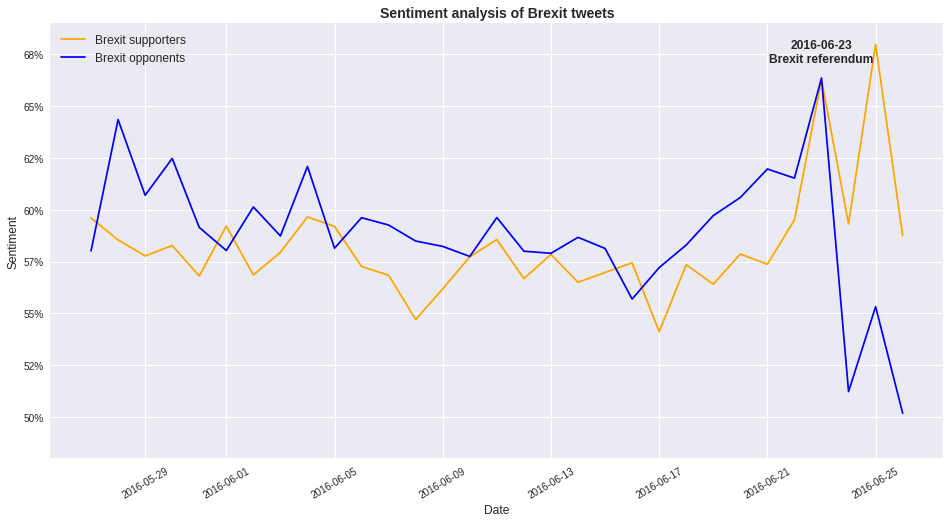

In [15]:
# plot timeline of sentiment analysis splitted to brexit supporters and brexit opponents
fig, ax = plt.subplots(figsize=(16,8))
ax.plot_date(df_leave['created_date'], df_leave['sentiment']*100, fmt='-', color='orange', label = 'Brexit supporters')
ax.plot_date(df_remain['created_date'], df_remain['sentiment']*100, fmt='-', color='blue', label = 'Brexit opponents')
ax.set_title('Sentiment analysis of Brexit tweets', fontsize=14, fontweight="bold")
ax.set_ylim(48,69)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sentiment', fontsize=12)
ax.tick_params(axis='x', labelrotation=30)
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

ax.text(pd.to_datetime('2016-06-23'), 67, 
        '2016-06-23\nBrexit referendum', 
        fontsize=12, fontweight='bold', 
        verticalalignment='bottom', 
        horizontalalignment='center')

plt.legend(loc='upper left', fontsize=12)
plt.savefig('brexit_tweets_plot_sentiment_analysis');